# Change & Consistency Analysis (Correlations RHR/HRV with Change)

In [1]:
# Setup 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statistics import stdev

pd.options.display.max_rows = 6000
pd.options.display.max_columns = 6000

# Read Data and Create Data Frames
#df_activs_plus = pd.read_csv('./df_activs_plus.csv')

# warnings supression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Downloading the data from the database

#### Creating a connection to the database

In [2]:
# SQAlchemy
import pandas as pd
from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string
from sqlalchemy.exc import SQLAlchemyError
from dotenv import dotenv_values # to load the data from .env file

#load the data from .env file
config = dotenv_values()

# define variables for the login
pg_user = config['AZURE_USER'] 
pg_host = config['AZURE_HOST']
pg_port = config['AZURE_PORT']
pg_db = config['AZURE_DB']
pg_schema = config['AZURE_SCHEMA']
pg_pass = config['AZURE_PASS']

# building the URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

#creating the engine

engine = create_engine(url, echo=False)
engine.url

#testing the connection
def test_db_connection(engine):
    try:
        connection = engine.connect() # including 'connection' as variable to close the connection
        print("Connection successful!")
        connection.close() # closing the connection
        return True
    except SQLAlchemyError as e:
        print(f"Connection failed: {e}")
        return False

test_db_connection(engine)

# building the search path
my_schema = pg_schema 

with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))

Connection successful!


#### Reading in the data from the database

In [3]:
# reading table into a dataframe

df_activs_plus = pd.read_sql(sql=text('SELECT * FROM public.df_activs_plus;'), con=engine)

df_phys = pd.read_sql(sql=text('SELECT * FROM public.df_phys;'), con=engine)


## Filtering the whole notebook for sport & timeperiod

In [4]:
# FILTERING THE WHOLE NOTEBOOK TO JUST ONE SPORT
#df_activs_plus = df_activs_plus[df_activs_plus ["sport"] == "Run"]   # ⚠️ uncomment this if you want to look for all sports 

# FILTERING THE WHOLE NOTEBOOK TO A TIMEPERIOD
#df_activs_plus = df_activs_plus[df_activs_plus["activity date"] < "2024-01-01"]    # ⚠️  uncomment this if you want to look for all time


## Preparation

#### 1a) Preparing `df_activs_m` 

In [5]:
#Creating new and condensed dataframe from df_activs_plus
df_acts = df_activs_plus.drop([
       #'activity id', 'date', 'activity date', 'sport', 'activity type',
       'start time', 
       #'moving time', 
       'elapsed time', 'finish time', 'swim pace','bike pace', 'run pace', 
       #'distance', 
        'avg heart rate','avg heart rate zone', 'max heart rate', 'max heart rate yearly',
        'avg speed', 'max speed', 'avg elapsed speed', 'relative effort',
       'calories', 'pool length', 'elevation gain', 'elevation loss',
       'elevation low', 'elevation high', 'max grade', 'avg grade',
       'avg watts', 'avg cadence', 'max cadence', 'activity name',
       'activity description', 'perceived exertion', 'event',
       'injury description', 'filename', 'filenumber', 
       'below zones','no hr collected', 'z1', 'z2', 'z3', 'z4', 'z5', 
       #'time low zones','time high zones', 'training mode', 
       'dist below zones','dist no hr collected', 'dist z1', 'dist z2', 'dist z3', 'dist z4','dist z5', 
       'cycle id', 'wake onset', 'to bed date', 'sleep onset',
       'sleep performance', 'recovery score', 'day strain', 
       #'rhr', 'hrv',
       'respiratory rate', 'asleep duration', 'in bed duration',
       'light sleep duration', 'deep sleep duration', 'rem sleep duration',
       'awake duration', 'sleep need', 'sleep debt', 'sleep efficiency',
       'sleep consistency', 'skin temp', 'blood oxygen', 'cal burned',
       'max hr', 'avg hr', 'cycle start time', 'cycle end time',
       'cycle timezone'
], axis=1)

# sorting the dataframe by start of the activity
df_acts.sort_values(by=['activity date'], inplace=True)

# Change data types
df_acts["date"] = pd.to_datetime(df_acts["date"], format="mixed",  dayfirst = True)
df_acts["activity date"] = pd.to_datetime(df_acts["activity date"], format="mixed",  dayfirst = True)
df_acts["moving time"]= pd.to_timedelta(df_acts["moving time"])


# Since I want to compare months' with each other, I create a month column
df_acts['month'] = df_acts['date'].dt.to_period('M') 
#df_acts['week'] = df_acts['date'].dt.to_period('W') 


In [6]:
# I also want the count of activities per month
#df_acts['activity count'] = df_acts.groupby('month')['date'].transform('count')
df_acts['activity count'] = 1

In [7]:
# Rearranging columns
df_acts = df_acts[[ 'activity id', 'date','month', #'week', 
        'activity date', 'sport', 'activity type',
       'moving time', 'distance',  "activity count", 'time low zones', 'time high zones',
       'training mode', 'rhr', 'hrv', 
 ]]

# dropping even more columns
df_acts = df_acts.drop([
       'activity id', 'date', 'activity date', 'sport', 'activity type', "time low zones","time high zones", "training mode", "rhr", "hrv"
       ], axis=1)

In [8]:
# Grouping by month
df_activs_m = df_acts.groupby('month').sum().reset_index()

In [9]:
# the activity dataframe and the physical dataframe are over different timeperiods. To align them, I drop rows outside the timeperiod here
df_activs_m = df_activs_m.drop(df_activs_m[df_activs_m["month"]< "2021-01"].index)
df_activs_m = df_activs_m.drop(df_activs_m[df_activs_m["month"]> "2024-12"].index)

In [10]:
#rounding columns
df_activs_m["distance"] = df_activs_m["distance"].astype(int)

In [11]:
df_activs_m

,month,moving time,distance,activity count
27,2021-01,0 days 04:24:32,45,9
28,2021-02,0 days 02:58:21,31,6
29,2021-03,0 days 01:01:14,11,2
30,2021-04,0 days 01:53:30,20,4
31,2021-05,0 days 05:25:33,57,10
32,2021-06,0 days 05:22:20,57,9
33,2021-07,0 days 04:55:24,50,12
34,2021-08,0 days 04:02:24,34,9
35,2021-09,0 days 03:57:19,43,5
36,2021-10,0 days 01:12:42,13,7


#### 1b) Preparing `df_phys_m` 

In [12]:
#Creating new and condensed dataframe
df_phys_m = df_phys.drop([
       'cycle id', 
       #'date', 
       'wake onset', 'to bed date', 'sleep onset',
       'sleep performance', 'recovery score', 'day strain', 
       #'rhr', 'hrv',
       'respiratory rate', 'asleep duration', 'in bed duration',
       'light sleep duration', 'deep sleep duration', 'rem sleep duration',
       'awake duration', 'sleep need', 'sleep debt', 'sleep efficiency',
       'sleep consistency', 'skin temp', 'blood oxygen', 'cal burned',
       'max hr', 'avg hr', 'cycle start time', 'cycle end time',
       'cycle timezone'
], axis=1)

# sorting the dataframe by date
df_phys_m.sort_values(by=['date'], inplace=True)

# Change data types
df_phys_m["date"] = pd.to_datetime(df_phys_m["date"], format="mixed",  dayfirst = True)

# Since I want to compare months' with each other, I create a month column
df_phys_m['month'] = df_phys_m['date'].dt.to_period('M') 

In [13]:
# Rearranging columns
df_phys_m = df_phys_m[[ 'date','month', 'rhr', 'hrv']]

# dropping even more columns
df_phys_m = df_phys_m.drop(['date'], axis=1)

In [14]:
#Creating new columns with monthly averages
df_phys_m['rhr per month'] = df_phys_m.groupby('month')['rhr'].transform('mean')
df_phys_m['hrv per month'] = df_phys_m.groupby('month')['hrv'].transform('mean')

# dropping the not anymore needed columns
df_phys_m = df_phys_m.drop(['rhr', 'hrv'], axis=1)

In [15]:
# Grouping by month
df_phys_m = df_phys_m.groupby('month').mean().reset_index()

In [16]:
# the activity dataframe and the physical dataframe are over different timeperiods. To align them, I drop rows outside the timeperiod here
df_phys_m = df_phys_m.drop(df_phys_m[df_phys_m["month"] < "2021-01"].index)


In [17]:
#rounding columns
df_phys_m["hrv per month"] = df_phys_m["hrv per month"].round(2)
df_phys_m["rhr per month"] = df_phys_m["rhr per month"].round(2)

#### 2) Joining `df_activs_m` and `df_phys_m` 

In [18]:
df_months = pd.merge(df_activs_m,df_phys_m, on="month", how="inner" )

In [19]:
# final renaming of columns
df_months = df_months.rename({"rhr per month": "rhr"}, axis=1)
df_months = df_months.rename({"hrv per month": "hrv"}, axis=1)
df_months = df_months.rename({"activity count": "activities"}, axis=1)
df_months = df_months.rename({"moving time": "train time"}, axis=1)

In [20]:
# aggregate new columns 
#df_months["moving time mins"] = df_months["moving time"].dt.minute

# Convert timedelta to total minutes
df_months['train time'] = (df_months["train time"].dt.total_seconds() /60).astype(int)

In [21]:
df_months

,month,train time,distance,activities,rhr,hrv
0,2021-01,264,45,9,50.03,53.90
1,2021-02,178,31,6,51.54,48.25
2,2021-03,61,11,2,52.70,46.90
3,2021-04,113,20,4,52.58,49.58
4,2021-05,325,57,10,52.68,49.81
5,2021-06,322,57,9,52.50,54.70
6,2021-07,295,50,12,51.00,59.84
7,2021-08,242,34,9,49.58,62.61
8,2021-09,237,43,5,50.14,61.03
9,2021-10,72,13,7,51.39,53.29


## Analysis

### How the general change of training routine influences HRV & RHR

Calculating the percentage change in moving time (train time change), distance (dist change), and number of activities (activs change) compared to the previous month 

In [24]:
# Compare each month to the last and return the change 
df_months['dist change'] = df_months['distance'].pct_change().fillna(0.5) # 🔴 check fillna value logic 🔴
df_months['activs change'] = df_months['activities'].pct_change().fillna(0.5) # 🔴 check fillna value logic 🔴
df_months['train time change'] = df_months['train time'].pct_change().fillna(0.5) # 🔴 check fillna value logic 🔴

# Convert all values to positive (absolute values)
df_months['dist change'] = df_months['dist change'].abs()
df_months['activs change'] = df_months['activs change'].abs()
df_months['train time change'] = df_months['train time change'].abs()

Creating a change coefficient (change coeff) that describes the mean change over all three aspects per months

In [26]:
# creating a change coefficient
df_months['change coeff'] = df_months[[ "activs change", "dist change", "train time change"]].mean(axis=1) #"dist change","train time change", 

In [27]:
# creating entries with the next month's hrv and rhr values, since we also want to analyse whether a consistent training period improved the next month's fitness
df_months["rhr next month"] = df_months["rhr"].shift(-1).fillna(50)
df_months["hrv next month"] = df_months["hrv"].shift(-1).fillna(53)

Labelling each month as consistent or inconsistent. (Inconsistent month = more change than normal (normal = average change over all months))

In [28]:
#### LABELING EACH MONTH BASED ON THE CHANGE COEFFICIENT

normal_change = round((df_months['change coeff'].mean()*100),1)

# create a list of our conditions
m_conditions = [
    ((df_months['change coeff']) <= (normal_change/100)),
    ((df_months['change coeff']) > (normal_change/100)),
    ]
# create a list of the values we want to assign for each condition
m_values = ['consistency', 'inconsistency']   

# create a new column and use np.select to assign values to it using our lists as arguments
df_months["period"] = np.select(m_conditions, m_values)


In [29]:
# rearranging columns
df_months = df_months[[ "month","change coeff", "period", "rhr","hrv","rhr next month",  "hrv next month"
 ]]

df_months["change coeff"] = df_months["change coeff"].round(2)


/var/folders/1m/_v4c_fx94fv55ggvl5l850080000gn/T/ipykernel_29504/545902765.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_months["change coeff"] = df_months["change coeff"].round(2)


In [30]:
# grouping by "consistency"
df_months_cons = df_months.groupby('period').mean().reset_index()

# dropping
df_months_cons = df_months_cons.drop([
       'month', 'change coeff'
       ], axis=1)

# renaming
df_months_cons = df_months_cons.rename({"rhr": "RHR during month"}, axis=1)
df_months_cons = df_months_cons.rename({"hrv": "HRV during month"}, axis=1)
df_months_cons = df_months_cons.rename({"rhr next month": "RHR one month later"}, axis=1)
df_months_cons = df_months_cons.rename({"hrv next month": "HRV one month later"}, axis=1)

In [31]:
df_months_cons

,period,RHR during month,HRV during month,RHR one month later,HRV one month later
0,consistency,51.251304,56.440435,51.169565,56.217391
1,inconsistency,52.693846,51.773077,52.836154,52.098462


Correlating the monthly change coefficient with HRV and RHR in order to see wether an athlete is fitter during an inconsistent or consistent months  

In [32]:
corr_rhr_change = df_months['change coeff'].corr(df_months['rhr next month']).round(2)
corr_hrv_change = df_months['change coeff'].corr(df_months['hrv next month']).round(2)

print("EFFECT ON NEXT MONTH")
print(f"The correlation between general change and next month's RHR is: {corr_rhr_change}")
print(f"The correlation between general change and next month's  HRV is: {corr_hrv_change}")


EFFECT ON NEXT MONTH
The correlation between general change and next month's RHR is: 0.37
The correlation between general change and next month's  HRV is: -0.34


In [33]:
corr_rhr_change = df_months['change coeff'].corr(df_months['rhr']).round(2)
corr_hrv_change = df_months['change coeff'].corr(df_months['hrv']).round(2)

print("EFFECT ON SAME MONTH")
print(f"The correlation between general change and the same month's RHR is: {corr_rhr_change}")
print(f"The correlation between general change and the same month's HRV is: {corr_hrv_change}")

EFFECT ON SAME MONTH
The correlation between general change and the same month's RHR is: 0.49
The correlation between general change and the same month's HRV is: -0.53


### Effect of change on NEXT MONTH's fitness

Calculating the effect of change on the next months' HRV & RHR

#### Linear Regression with HRV next month

In [34]:
# import the statsmodels.api module
import statsmodels.api as sm

# Choose the independent variable, the predictor X
X = df_months[['change coeff']]

# Define dependent variable (since it's always a single variable, we can use dot notation here)
y = df_months["hrv next month"]

display(X.head())
display(y.head())

,change coeff
0,0.50
1,0.32
2,0.66
3,0.89
4,1.74


0    48.25
1    46.90
2    49.58
3    49.81
4    54.70
Name: hrv next month, dtype: float64

**Deep Dive: Why do we have to add a constant?**  
Statsmodel does not fit the intercept by default! Thus, if we don't add a constant, we won't have an adjustable intercept and our model is forced to let the regression line go through the origin of the coordinate system.
The “const” column provides a placeholder — a bunch of 1s as constants which can be multiplied by $\beta_0$.

In [35]:
# Since our statsmodel OLS model needs an adjustable intercept, we add a column of 1s to:
X = sm.add_constant(X)
display(X.head())

,const,change coeff
0,1.0,0.50
1,1.0,0.32
2,1.0,0.66
3,1.0,0.89
4,1.0,1.74


Now, our data is prepared for modeling!  

The following steps are:
- creating a model based on the modules notation,
- fitting the model to our data (this is the part where the sum of squared residuals is reduced to min - and passing the model results in a result variable)
- print a summary with the models statistics

In [36]:
# create an OLS model
our_model = sm.OLS(y, X)

# use the data to calculate the intercept and slope
model_results = our_model.fit()

# return the output of the model
model_results.summary() # summary contains eg. 'const' (intercept) and 'slope' of the regression equation.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hrv next month   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     4.519
Date:                Fri, 14 Mar 2025   Prob (F-statistic):             0.0409
Time:                        16:40:25   Log-Likelihood:                -106.01
No. Observations:                  36   AIC:                             216.0
Df Residuals:                      34   BIC:                             219.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           56.5553      1.166     48.508      0.000      54.186      58.925
change coeff    -3.4013      1.600     -2.126      0.041      -6.653      -0.150
==============================================================================
Omnibus:                        2.311   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.315   Jarque-Bera (JB):                1.722
Skew:                          -0.536   Prob(JB):                        0.423
Kurtosis:                       2.984   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared, $\textbf{R}^2$ - Proportion of the variation in $y$ that is explained by the model. Measured on a scale from 0 (bad) to 1 (good)  
**const coef** - This is the intercept, in other words: value of y when x = 0  
**weight coef** - This is the slope, in other words: Amount, y changes for each unit change of x  

In [37]:
# print out the intercept and slope of your model by addressing the parameters via ".params"
# (you can also find it in the table above by looking at const coef and weight coef)
intercept, hrv_slope = model_results.params

print(f'intercept: {intercept}, slope: {hrv_slope}')

intercept: 56.5553402760313, slope: -3.4012551727291385


In [38]:
print(f"for each 100% change the HRV changes by {round(hrv_slope*1, 1)} ms")  

for each 100% change the HRV changes by -3.4 ms


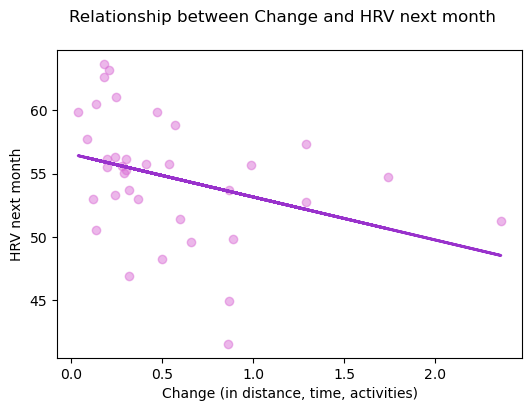

In [39]:
# Plotting the results of our model
fig, ax = plt.subplots(figsize=(6, 4))

x = df_months['change coeff']
y = df_months['hrv next month']

# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Relationship between Change and HRV next month')

# plotting the regression line with the help of our calculated intercept and slope variables
ax.plot(x, x*hrv_slope+intercept, '-', color='darkorchid', linewidth=2);
ax.set_xlabel("Change (in distance, time, activities)");
ax.set_ylabel("HRV next month");

##### Checking Significance (Change & HRV)

In [40]:
# checking significance
from scipy.stats import spearmanr

corr, p_value = spearmanr(df_months['change coeff'], df_months['hrv next month'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

Spearman correlation: -0.47862483814659795, p-value: 0.0031481060690403775


#### Linear Regression with RHR next month

In [41]:
# import the statsmodels.api module
import statsmodels.api as sm

# Choose the independent variable, the predictor X
X = df_months[['change coeff']]

# Define dependent variable (since it's always a single variable, we can use dot notation here)
y = df_months["rhr next month"]

display(X.head())
display(y.head())

,change coeff
0,0.50
1,0.32
2,0.66
3,0.89
4,1.74


0    51.54
1    52.70
2    52.58
3    52.68
4    52.50
Name: rhr next month, dtype: float64

**Deep Dive: Why do we have to add a constant?**  
Statsmodel does not fit the intercept by default! Thus, if we don't add a constant, we won't have an adjustable intercept and our model is forced to let the regression line go through the origin of the coordinate system.
The “const” column provides a placeholder — a bunch of 1s as constants which can be multiplied by $\beta_0$.

In [42]:
# Since our statsmodel OLS model needs an adjustable intercept, we add a column of 1s to:
X = sm.add_constant(X)
display(X.head())

,const,change coeff
0,1.0,0.50
1,1.0,0.32
2,1.0,0.66
3,1.0,0.89
4,1.0,1.74


Now, our data is prepared for modeling!  

The following steps are:
- creating a model based on the modules notation,
- fitting the model to our data (this is the part where the sum of squared residuals is reduced to min - and passing the model results in a result variable)
- print a summary with the models statistics

In [43]:
# create an OLS model
our_model = sm.OLS(y, X)

# use the data to calculate the intercept and slope
model_results = our_model.fit()

# return the output of the model
model_results.summary() # summary contains eg. 'const' (intercept) and 'slope' of the regression equation.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rhr next month   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     5.275
Date:                Fri, 14 Mar 2025   Prob (F-statistic):             0.0279
Time:                        16:40:25   Log-Likelihood:                -64.260
No. Observations:                  36   AIC:                             132.5
Df Residuals:                      34   BIC:                             135.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           51.1530      0.366    139.919      0.000      50.410      51.896
change coeff     1.1522      0.502      2.297      0.028       0.133       2.172
==============================================================================
Omnibus:                        3.259   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                2.509
Skew:                           0.646   Prob(JB):                        0.285
Kurtosis:                       3.042   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared, $\textbf{R}^2$ - Proportion of the variation in $y$ that is explained by the model. Measured on a scale from 0 (bad) to 1 (good)  
**const coef** - This is the intercept, in other words: value of y when x = 0  
**weight coef** - This is the slope, in other words: Amount, y changes for each unit change of x  

In [44]:
# print out the intercept and slope of your model by addressing the parameters via ".params"
# (you can also find it in the table above by looking at const coef and weight coef)
intercept, rhr_slope = model_results.params

print(f'intercept: {intercept}, slope: {rhr_slope}')

intercept: 51.15301999105806, slope: 1.152240182293454


In [45]:
print(f"for each 100% change the RHR changes by {round(rhr_slope*1, 1)} bpm")  

for each 100% change the RHR changes by 1.2 bpm


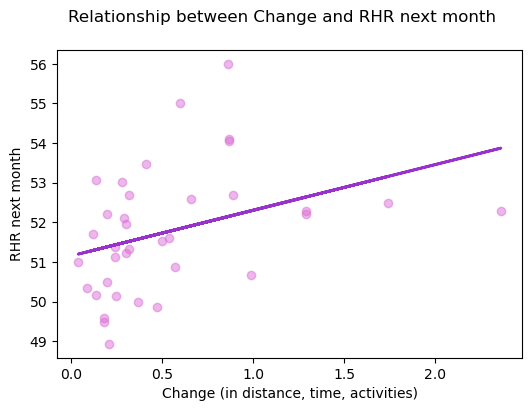

In [46]:
# Plotting the results of our model
fig, ax = plt.subplots(figsize=(6, 4))

x = df_months['change coeff']
y = df_months['rhr next month']

# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Relationship between Change and RHR next month')

# plotting the regression line with the help of our calculated intercept and slope variables
ax.plot(x, x*rhr_slope+intercept, '-', color='darkorchid', linewidth=2);
ax.set_xlabel("Change (in distance, time, activities)");
ax.set_ylabel("RHR next month");

##### Checking Significance (Change & RHR)

In [47]:
# checking significance
from scipy.stats import spearmanr

corr, p_value = spearmanr(df_months['change coeff'], df_months['rhr next month'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

Spearman correlation: 0.4900837455267302, p-value: 0.0024124632682249046


### Effect of change on SAME MONTH's fitness

Calculating the effect of change on HRV & RHR during the same month in which the change occurred. 

#### Linear Regression with HRV this same month

In [48]:
# import the statsmodels.api module
import statsmodels.api as sm

# Choose the independent variable, the predictor X
X = df_months[['change coeff']]

# Define dependent variable (since it's always a single variable, we can use dot notation here)
y = df_months["hrv"]

display(X.head())
display(y.head())

,change coeff
0,0.50
1,0.32
2,0.66
3,0.89
4,1.74


0    53.90
1    48.25
2    46.90
3    49.58
4    49.81
Name: hrv, dtype: float64

**Deep Dive: Why do we have to add a constant?**  
Statsmodel does not fit the intercept by default! Thus, if we don't add a constant, we won't have an adjustable intercept and our model is forced to let the regression line go through the origin of the coordinate system.
The “const” column provides a placeholder — a bunch of 1s as constants which can be multiplied by $\beta_0$.

In [49]:
# Since our statsmodel OLS model needs an adjustable intercept, we add a column of 1s to:
X = sm.add_constant(X)
display(X.head())

,const,change coeff
0,1.0,0.50
1,1.0,0.32
2,1.0,0.66
3,1.0,0.89
4,1.0,1.74


Now, our data is prepared for modeling!  

The following steps are:
- creating a model based on the modules notation,
- fitting the model to our data (this is the part where the sum of squared residuals is reduced to min - and passing the model results in a result variable)
- print a summary with the models statistics

In [50]:
# create an OLS model
our_model = sm.OLS(y, X)

# use the data to calculate the intercept and slope
model_results = our_model.fit()

# return the output of the model
model_results.summary() # summary contains eg. 'const' (intercept) and 'slope' of the regression equation.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    hrv   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     13.29
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           0.000881
Time:                        16:40:25   Log-Likelihood:                -102.27
No. Observations:                  36   AIC:                             208.5
Df Residuals:                      34   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           57.5766      1.051     54.795      0.000      55.441      59.712
change coeff    -5.2576      1.442     -3.646      0.001      -8.188      -2.327
==============================================================================
Omnibus:                       11.140   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.102
Skew:                          -0.930   Prob(JB):                      0.00236
Kurtosis:                       5.147   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared, $\textbf{R}^2$ - Proportion of the variation in $y$ that is explained by the model. Measured on a scale from 0 (bad) to 1 (good)  
**const coef** - This is the intercept, in other words: value of y when x = 0  
**weight coef** - This is the slope, in other words: Amount, y changes for each unit change of x  

In [51]:
# print out the intercept and slope of your model by addressing the parameters via ".params"
# (you can also find it in the table above by looking at const coef and weight coef)
intercept, hrv_slope = model_results.params

print(f'intercept: {intercept}, slope: {hrv_slope}')

intercept: 57.57655822035254, slope: -5.257561901278031


In [52]:
print(f"for each 100% change the HRV changes by {round(hrv_slope*1, 1)} ms")  

for each 100% change the HRV changes by -5.3 ms


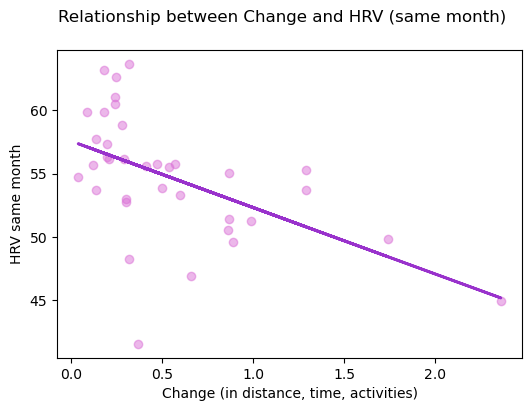

In [53]:
# Plotting the results of our model
fig, ax = plt.subplots(figsize=(6, 4))

x = df_months['change coeff']
y = df_months['hrv']

# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Relationship between Change and HRV (same month)')

# plotting the regression line with the help of our calculated intercept and slope variables
ax.plot(x, x*hrv_slope+intercept, '-', color='darkorchid', linewidth=2);
ax.set_xlabel("Change (in distance, time, activities)");
ax.set_ylabel("HRV same month");

##### Checking Significance (Change & HRV)

###### Checking Normality

In [54]:
import scipy.stats as stats

# Shapiro-Wilk test
# _ is a throwaway variable we are not really interested in this value 
# but rather only the p-value
_, p_change_coeff = stats.shapiro(df_months['change coeff'])  
_, p_hrv = stats.shapiro(df_months['hrv'])
print(f'Shapiro-Wilk p-value (change coeff): {p_change_coeff}')
print(f'Shapiro-Wilk p-value (hrv): {p_hrv}')

print("change coeff is not normally distributed")
print("hrv is normally distributed")


Shapiro-Wilk p-value (change coeff): 9.666084815707971e-06
Shapiro-Wilk p-value (hrv): 0.5321890497011001
change coeff is not normally distributed
hrv is normally distributed


###### Checking Significance

In [55]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(df_months['change coeff'], df_months['hrv'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

Spearman correlation: -0.6267062381650503, p-value: 4.3251660533810696e-05


#### Linear Regression with RHR this same month

In [56]:
# import the statsmodels.api module
import statsmodels.api as sm

# Choose the independent variable, the predictor X
X = df_months[['change coeff']]

# Define dependent variable (since it's always a single variable, we can use dot notation here)
y = df_months["rhr"]

display(X.head())
display(y.head())

,change coeff
0,0.50
1,0.32
2,0.66
3,0.89
4,1.74


0    50.03
1    51.54
2    52.70
3    52.58
4    52.68
Name: rhr, dtype: float64

**Deep Dive: Why do we have to add a constant?**  
Statsmodel does not fit the intercept by default! Thus, if we don't add a constant, we won't have an adjustable intercept and our model is forced to let the regression line go through the origin of the coordinate system.
The “const” column provides a placeholder — a bunch of 1s as constants which can be multiplied by $\beta_0$.

In [57]:
# Since our statsmodel OLS model needs an adjustable intercept, we add a column of 1s to:
X = sm.add_constant(X)
display(X.head())

,const,change coeff
0,1.0,0.50
1,1.0,0.32
2,1.0,0.66
3,1.0,0.89
4,1.0,1.74


Now, our data is prepared for modeling!  

The following steps are:
- creating a model based on the modules notation,
- fitting the model to our data (this is the part where the sum of squared residuals is reduced to min - and passing the model results in a result variable)
- print a summary with the models statistics

In [58]:
# create an OLS model
our_model = sm.OLS(y, X)

# use the data to calculate the intercept and slope
model_results = our_model.fit()

# return the output of the model
model_results.summary() # summary contains eg. 'const' (intercept) and 'slope' of the regression equation.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rhr   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     10.80
Date:                Fri, 14 Mar 2025   Prob (F-statistic):            0.00236
Time:                        16:40:25   Log-Likelihood:                -61.868
No. Observations:                  36   AIC:                             127.7
Df Residuals:                      34   BIC:                             130.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           50.9442      0.342    148.922      0.000      50.249      51.639
change coeff     1.5429      0.469      3.287      0.002       0.589       2.497
==============================================================================
Omnibus:                       10.207   Durbin-Watson:                   1.302
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.749
Skew:                           0.959   Prob(JB):                      0.00764
Kurtosis:                       4.679   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared, $\textbf{R}^2$ - Proportion of the variation in $y$ that is explained by the model. Measured on a scale from 0 (bad) to 1 (good)  
**const coef** - This is the intercept, in other words: value of y when x = 0  
**weight coef** - This is the slope, in other words: Amount, y changes for each unit change of x  

In [59]:
# print out the intercept and slope of your model by addressing the parameters via ".params"
# (you can also find it in the table above by looking at const coef and weight coef)
intercept, rhr_slope = model_results.params

print(f'intercept: {intercept}, slope: {rhr_slope}')

intercept: 50.944187808490256, slope: 1.5429212678235302


In [60]:
print(f"for each 100% change the RHR changes by {round(rhr_slope*1, 1)} bpm") 

for each 100% change the RHR changes by 1.5 bpm


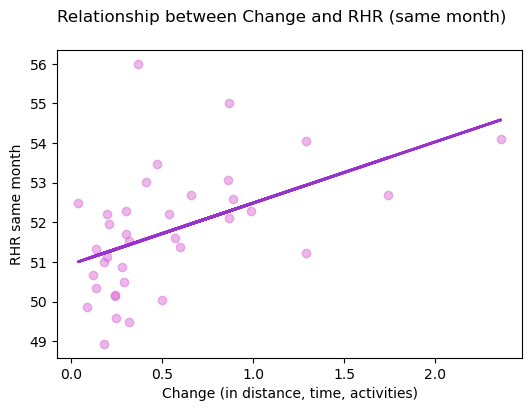

In [61]:
# Plotting the results of our model
fig, ax = plt.subplots(figsize=(6, 4))

x = df_months['change coeff']
y = df_months['rhr']

# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Relationship between Change and RHR (same month)')

# plotting the regression line with the help of our calculated intercept and slope variables
ax.plot(x, x*rhr_slope+intercept, '-', color='darkorchid', linewidth=2);
ax.set_xlabel("Change (in distance, time, activities)");
ax.set_ylabel("RHR same month");

##### Checking Significance (Change & RHR)

###### Checking Normality

In [62]:
import scipy.stats as stats

# Shapiro-Wilk test
# _ is a throwaway variable we are not really interested in this value 
# but rather only the p-value
_, p_change_coeff = stats.shapiro(df_months['change coeff'])  
_, p_rhr = stats.shapiro(df_months['rhr'])
print(f'Shapiro-Wilk p-value (change coeff): {p_change_coeff}')
print(f'Shapiro-Wilk p-value (rhr): {p_rhr}')

print("change coeff is not normally distributed")
print("rhr is normally distributed")


Shapiro-Wilk p-value (change coeff): 9.666084815707971e-06
Shapiro-Wilk p-value (rhr): 0.6110842157456045
change coeff is not normally distributed
rhr is normally distributed


###### Checking Significance

In [63]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(df_months['change coeff'], df_months['rhr'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

Spearman correlation: 0.5813265082926448, p-value: 0.00020075519207964066
